## Pitchfork Review Web Crawler

I tend to gravitate toward Pitchfork for music reviews because of their unique 0.0-10.0 rating scale. When I approach new music from a critical perspective, there is a massive difference between a score of 8.6 and 9.4. However, for most music review sites, those scores would both round to 9/10 or four-and-a-half stars. 

So when I first thought about diving into a fun music dataset, I thought it would be interesting to look into Pitchfork's reviews—particularly to see how the publication has changed since it began in the late 90s. I found a few existing datasets, but none of them had all the features I wanted, so I built this web crawler to scrape data directly from Pitchfork. 

### Step 1: Import necessary libraries for scraping webpages and structuring data tables

In [ ]:
#Import necessary modules
import urllib.request as ur #Handles URLs
from bs4 import BeautifulSoup #Parses webpage content
import requests
from lxml import html
import numpy as np
import pandas as pd
import time

### Step 2: Store all Pitchfork pages with album reviews

All Pitchfork albums are located under the base URL http://pitchfork.com/reviews/albums/?page=. When I ran my web crawler, there were 1741 pages with 12 reviews on each page. For this step, I simply needed to get a list of all page URLs.

In [ ]:
#Get the base URL used for all Pitchfork reviews
base_url = "http://pitchfork.com/reviews/albums/?page="

#Initialize page counter
page_num = 1

#Initialize list of pages
page_li = []

#Populate currently empty list of pitchfork review index pages
while page_num < 1741: #or however many pages are available/necessary
    #Convert page number to string to be appended to url
    page_num_str = str(page_num)
    #Create url of index page to scrape for review page urls
    full_url = base_url + page_num_str
    #Append to list of review page urls to scrape
    page_li.append(full_url)
    #Bump counter
    page_num = page_num + 1

### Step 3: Store all review URLs

Once I had my list of review pages, I needed to get the 12 individual review URLs from each. Web scraping will depend on how the webpage organizes tags. Looking at my browser's console, I found that I needed to get the *fragment_list* class and all of its 12 *a href* tags:

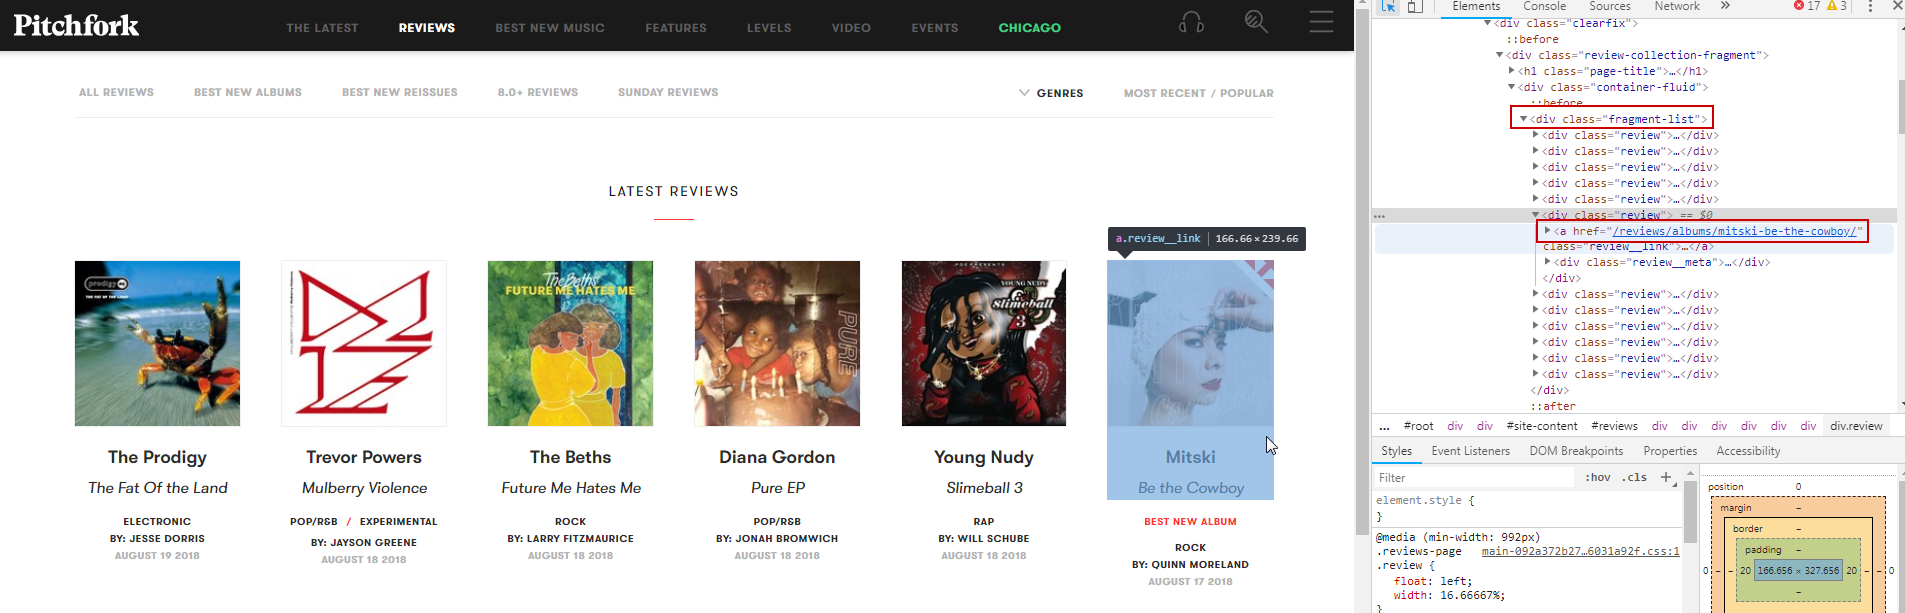

Adding a simple if statement checking that the URL includes the string "/reviews/albums/" and not "?genre," and I had all the review URLs. This part takes quite a bit of time, so I also added a print statement to let me know when the loop finished adding chunks of 50 URLs to the list. 

In [ ]:
#Create empty list of album review page urls
review_urls=[]

#Initialize iteration count to keep track of the scraper's progress
current_iteration = 0

#For each item in the list of review index pages do following:
for item in page_li:
    #Open the review index page and find anything with "a" tag used in links
    full_url_req = ur.Request(item)
    full_url_response = ur.urlopen(full_url_req)
    soup = BeautifulSoup(full_url_response)
    fragment_lists = soup.find("div", class_="fragment-list")
    a_tags = fragment_lists.find_all("a")
    for a_tag in a_tags:
        #Grab the link in the "href" in "a" tag
        current_href=a_tag.get('href')
        #There are two criteria for it being a review page: 1) includes string "/reviews/albums/" and longer than 22 characters
        if current_href[0:16] == "/reviews/albums/" and current_href[16:22] != "?genre" and len(current_href) > 22:
            list_url = "http://pitchfork.com" + current_href
            #Append to list of review page urls
            review_urls.append(list_url)
    
    #Report completion for every fifty iterations
    if current_iteration % 50 == 0 and current_iteration != 0:
        print("Completed iteration " + str(current_iteration))
    
    #Bump iteration
    current_iteration = current_iteration + 1

#Print completion
print("Completed all iterations")

### Step 4: Extract all necessary information from each review

Now that I had all the review URLs, I needed to extract the data I wanted from each article:

* Full Review
* Review Summary
* Review Date
* Review Score
* Critic's Name
* Critic's Title
* Album Genre
* Album Label
* Album Artist
* Album Name
* Whether or not the album received a Best New Music/Best New Reissue Stamp
* Album Release Year

Once again, I found the HTML tags within my browser's console. Unfortunately, not all review URLs had every piece of information—especially for earlier years. In order to avoid errors, I added try-except logic for every piece. Finally, I added another print function to put my mind at ease while the code looped through each URL.

In [ ]:
#Initialize outlist
outlist = []

#Initialize iteration count
current_iteration = 0

for url in review_urls:
    #Request a url from list of review page urls and get text
    resp = requests.get(url)
    doc = html.fromstring(resp.text)

    #Gather all important aspects of the review
    
    #Review Body
    try:
        review_body = doc.find('.//div[@class="contents dropcap"]').text_content().strip().encode('utf-8')
    except:
        review_body = "Not Available".encode('utf-8')
    
    #Review Summary
    try:
        review_summary = doc.find('.//div[@class="review-detail__abstract"]').text_content().strip().encode('utf-8')
    except:
        review_summary = "Not Available".encode('utf-8')
    
    #Review Date
    try:
        review_date = doc.find(".//time[@class='pub-date']").text_content().strip().encode('utf-8')
    except:
        review_date = "Not Available".encode('utf-8')
    
    #Review Score
    try:
        review_score = doc.find(".//span[@class='score']").text_content().strip().encode('utf-8')
    except:
        review_score = "Not Available".encode('utf-8')
    
    #Article Author's Name
    try:
    #Author Information
        author_name = doc.find(".//a[@class='authors-detail__display-name']").text_content().strip().encode('utf-8')
    except:
        author_name = "Not Available".encode('utf-8')
    
    #Article Author's Position/Title
    try:
        author_title = doc.find(".//span[@class='authors-detail__title']").text_content().strip().encode('utf-8')
    except:
        author_title = "Not Available".encode('utf-8')
    
    #Album Genre
    try:
        album_genre = doc.find(".//li[@class='genre-list__item']").text_content().strip().encode('utf-8')
    except:
        album_genre = "Not Available".encode('utf-8')
    
    #Album Label
    try:
        album_label = doc.find(".//li[@class='labels-list__item']").text_content().strip().encode('utf-8')
    except:
        album_label = "Not Available".encode('utf-8')
    
    #Album Artist
    try:
        album_artist = doc.find(".//ul[@class='artist-links artist-list single-album-tombstone__artist-links']").text_content().strip().encode('utf-8')
    except:
        album_artist = "Not Available".encode('utf-8')
    
    #Album Name
    try:
        album_title = doc.find(".//h1[@class='single-album-tombstone__review-title']").text_content().strip().encode('utf-8')
    except:
        album_title = "Not Available".encode('utf-8')
    
    #Best New Music/Reissue Tag
    try:
        album_bnm = doc.find(".//p[@class='bnm-txt']").text_content().strip().encode('utf-8')
    except:
        album_bnm = "Not Available".encode('utf-8')
    
    #Album Release Year
    try:
        album_year = doc.find(".//span[@class='single-album-tombstone__meta-year']").text_content().strip().encode('utf-8')
    except:
        album_year = "Not Available".encode('utf-8')
        
    #Put current loop's information in a list
    inlist = [album_artist,album_title,album_genre,album_label,album_bnm,album_year,
              author_name,author_title,
              review_summary,review_body,review_date,review_score,url]
    
    #Append current album information to outlist
    outlist.append(inlist)
    
    #Report completion for every fifty iterations
    if current_iteration % 50 == 0 and current_iteration != 0:
        print("Completed iteration " + str(current_iteration))
    
    #Bump iteration count
    current_iteration = current_iteration + 1

#Print completion
print("Completed all iterations")

### Step 6: Create a data table with all scraped information

When my loop finished scraping data, I simply needed to put the information in a Pandas dataframe and decode all UTF-8 encoding. 

In [ ]:
#Create dataframe from outlist
df = pd.DataFrame(outlist, columns = ["Artist", "Album", "Genre", "Label", "BNM", "Year","Author", "Title",
                                      "Summary", "Review", "Date", "Score", "URL"])

In [ ]:
#Decode all columns except URL
str_df = df.select_dtypes([np.object]).drop('URL', axis=1)
str_df = str_df.stack().str.decode('utf-8').unstack()

for col in str_df:
    df[col] = str_df[col]

### Step 7: Cleansing the Raw Data

Now that I had the raw data, I needed to do a little maintenance with the date-related variables. Reissued albums had year values that showed both release and review years, so I split them into two separate features. 

In [ ]:
#Replace bullet point with Not Available
df.Year[df.Year=="•"] = "Not Available"

#Get Original_Year and Reissue_Year variables
df['Original_Year'] = df.Year.str.partition('/')[0]
df['Reissue_Year'] =  df.Year.str.partition('/')[2]

#Designate whitespaces as missings
df['Reissue_Year'] = df['Reissue_Year'].replace(r'\s+|^$', np.nan, regex=True)

### Step 8: Designate likely new albums vs. reissues

Pitchfork reviews plenty of reissued albums, and they have recently started reviewing impactful older albums on Sundays. I knew I would probably want to filter the data to new album reviews for my analysis, so I created some rules to indicate which reviews likely corresponded with new vs. old albums.

* If the album has Year="Not Available," it is not new. (Compilation of prior releases)
* If the album has a Reissue_Year, it is not new.
* If the album has Year < Review Year - 1, it is not new
* If the album name contains "anniversary edition," it is not new
* If BNM is "Best New Reissue," it is not new
* If BNM is "Best New Music," it is new
* If the album summary or review includes the word "reissue" it is not new
* The remainder are considered new

In [ ]:
#Get date
df['Date'] = pd.to_datetime(df['Date'], format='%B %d %Y')
df['Review_Year'] = df['Date'].dt.year

#Create a variable to denote the difference between when the album was released vs when it was reviewed
df['Original_Year'] = pd.to_numeric([np.NaN if x == 'Not Available' or len(x) != 4 else x for x in df['Original_Year']])
df['Review_Release_Difference'] = df['Review_Year'] - df['Original_Year']

#Was the album released two or more years before the review?
df['Large_Time_Gap'] = [0 if x in range(0,2) else 1 for x in df['Review_Release_Difference']]

#Does the album name contain "anniversary edition"?
df['Anniversary_Edition'] = pd.to_numeric(df['Album'].str.contains('anniversary edition', case=False, regex=False))

#Does the album have "Best new reissue" tag?
df['Best_New_Reissue'] = [1 if x == 'Best new reissue' else 0 for x in df['BNM']]

#Does the summary include the word 'Reissue'
df['Summary_Contains_Reissue'] = pd.to_numeric(df['Summary'].str.contains('reissue', case=False))

#Does the review include the word 'Reissue'
df['Review_Contains_Reissue'] = pd.to_numeric(df['Review'].str.contains('reissue', case=False))

#Create a variable showing the number of rules broken
df['Broken_Rules_Count'] = df['Large_Time_Gap'] + df['Anniversary_Edition'] + df['Best_New_Reissue'] + df['Summary_Contains_Reissue'] + df['Review_Contains_Reissue']

#Create New_Album variable indicating whether any rules were broken
df['New_Album'] = [1 if x in range(0,1) else 0 for x in df['Broken_Rules_Count']]

#Ensure albums with "Best new music" are set as new
df['New_Album'] = np.where(df['BNM']=='Best new music', 1, df['New_Album'])

### Step 9: Store Cleansed Dataset

Now we have a nice dataset to use for analysis! You can find the pickle file at https://drive.google.com/open?id=1dnlZn10IrZHCG3drdf_U8XymNWe5OqQZ.

In [ ]:
#Write dataset to pickle
df.to_pickle("p4k_clenased.pkl")